In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix)
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
#Load data
df = pd.read_csv('Churn_Modelling_Cleaned.csv')

In [3]:
#Data Missing
df.info()
print(df.describe())
print(f"Missing values:\n{df.isnull().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288      

In [4]:
#Deduplication
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Removed {before - after} duplicate rows.")

Removed 0 duplicate rows.


In [5]:
#Variable Grouping
num_cols = ['CreditScore','Age','Tenure','Balance','EstimatedSalary','NumOfProducts']
bin_cols = ['HasCrCard','IsActiveMember','Exited']
cat_cols = ['Geography','Gender']
target = 'Exited'

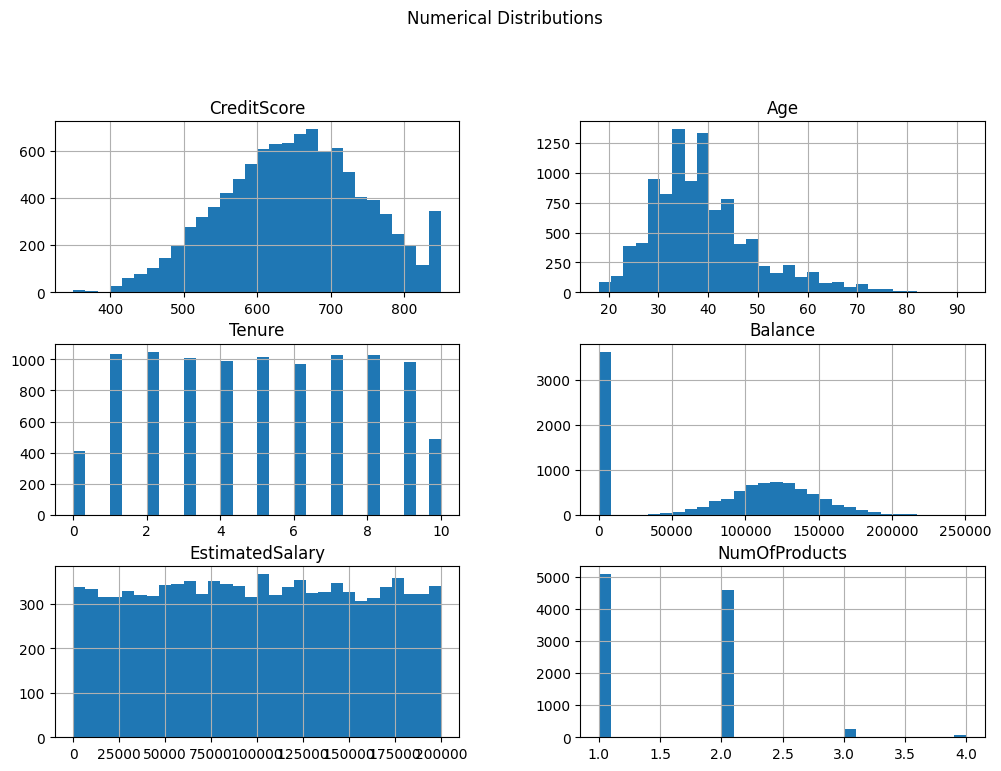

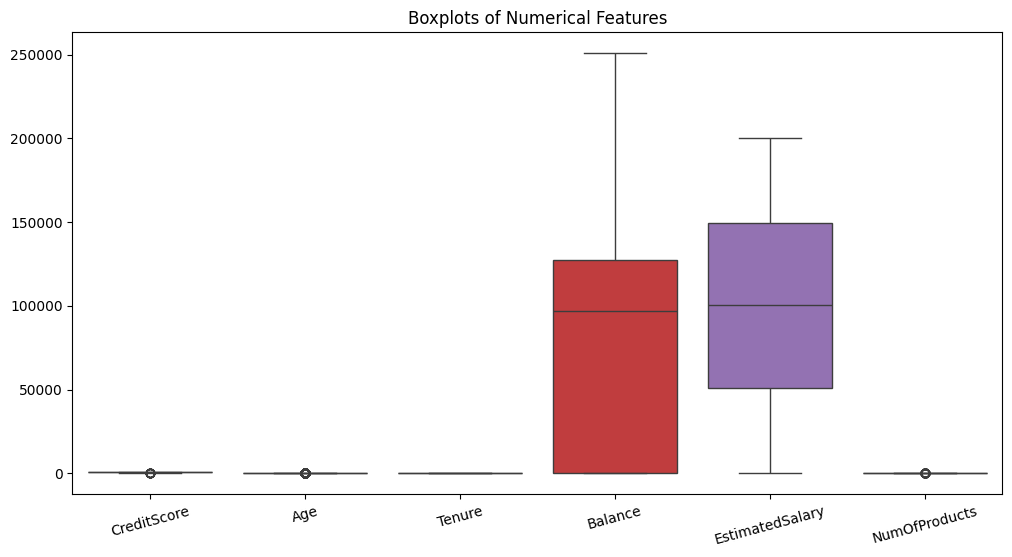

In [6]:
# bar chart
df[num_cols].hist(bins=30, figsize=(12,8))
plt.suptitle('Numerical Distributions', y=1.02)
plt.show()

# box plot
plt.figure(figsize=(12,6))
sns.boxplot(data=df[num_cols])
plt.title('Boxplots of Numerical Features')
plt.xticks(rotation=15)
plt.show()

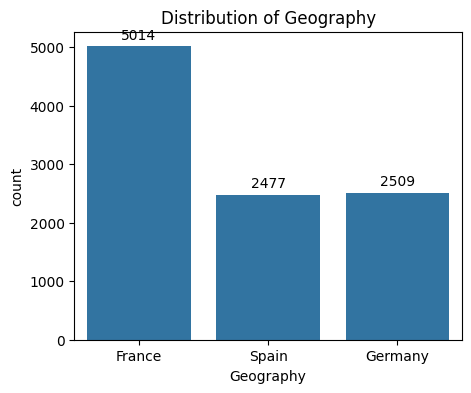

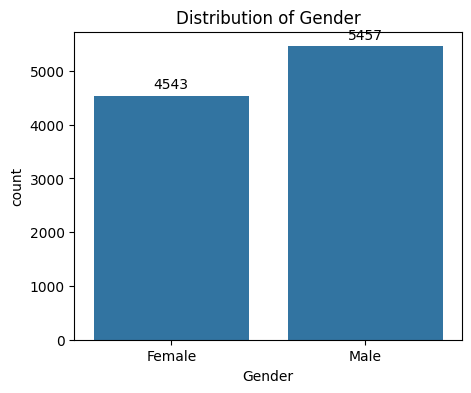

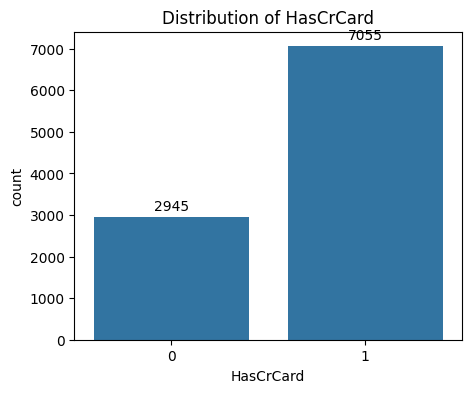

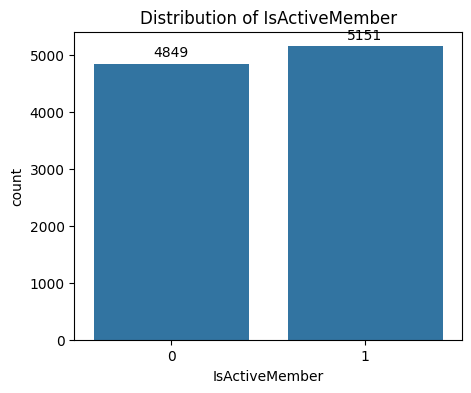

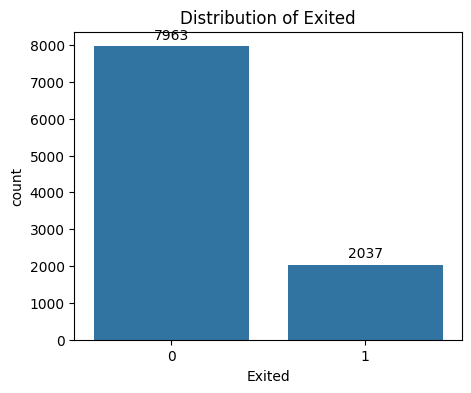

In [7]:
for col in cat_cols + bin_cols:
    plt.figure(figsize=(5,4))
    ax = sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    #Mark the number
    for p in ax.patches:
            ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                        ha='center', va='bottom', xytext=(0,3), textcoords='offset points')
    plt.show()

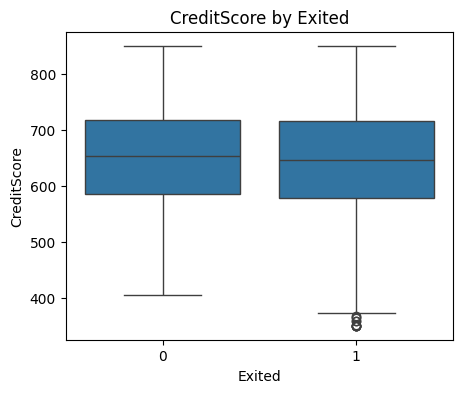

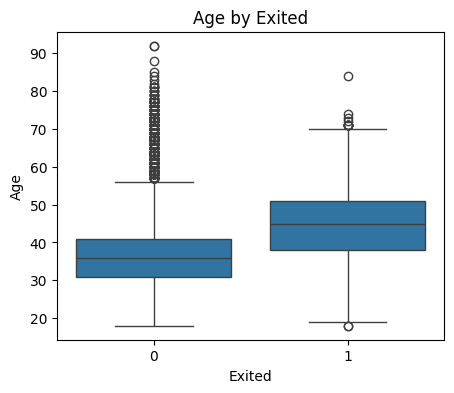

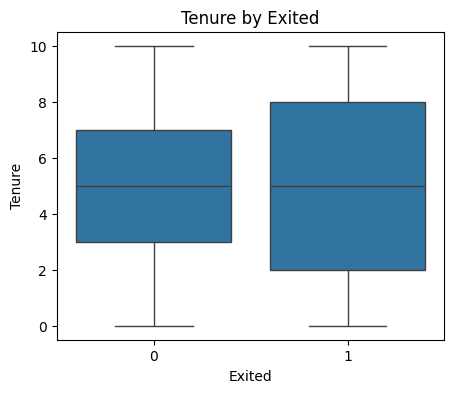

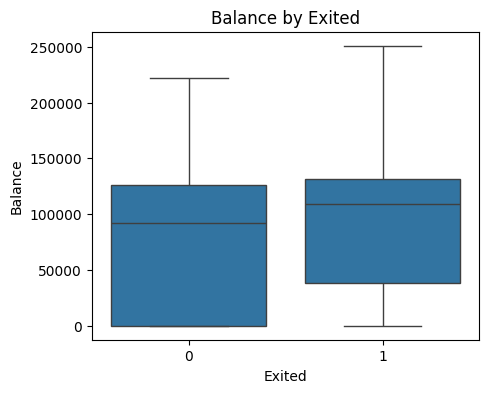

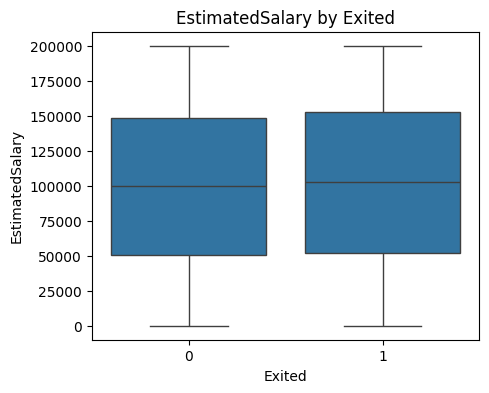

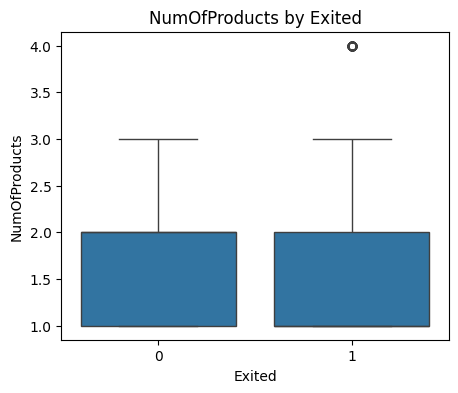

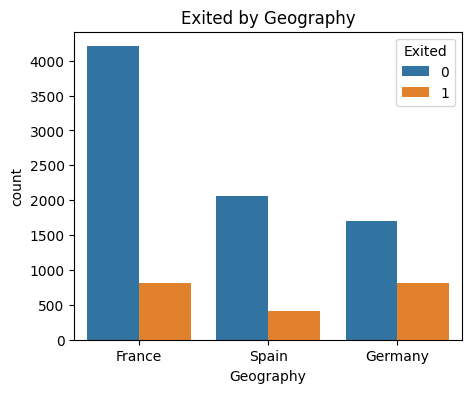

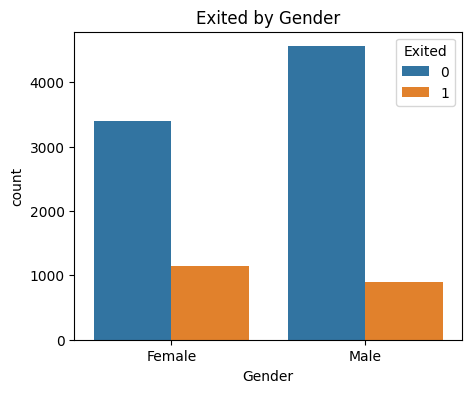

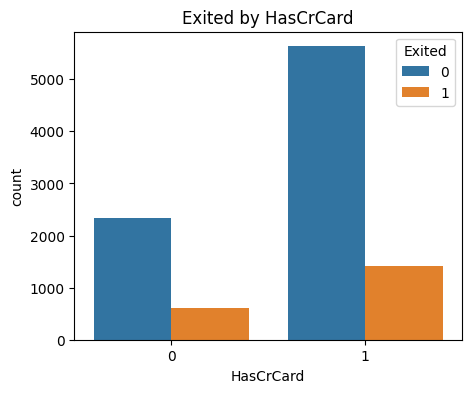

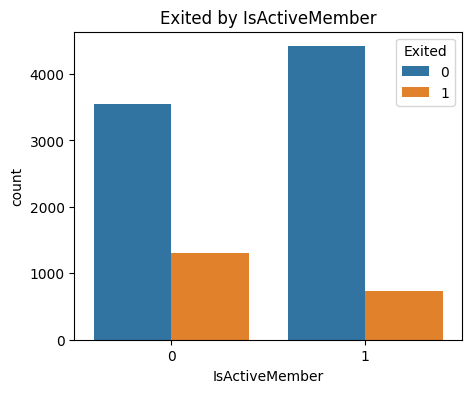


Churn Rate by Geography:
Geography
Germany    32.44%
Spain      16.67%
France     16.15%
Name: Exited, dtype: object

Churn Rate by Gender:
Gender
Female    25.07%
Male      16.46%
Name: Exited, dtype: object

Churn Rate by HasCrCard:
HasCrCard
0    20.81%
1    20.18%
Name: Exited, dtype: object

Churn Rate by IsActiveMember:
IsActiveMember
0    26.85%
1    14.27%
Name: Exited, dtype: object


In [8]:
# Numeric Variables vs. Dropout: Boxplots
for col in num_cols:
    plt.figure(figsize=(5,4))
    sns.boxplot(x=target, y=col, data=df)
    plt.title(f'{col} by {target}')
    plt.show()

# Categorical Variables vs. Dropout: Grouped Bar Chart
for col in cat_cols + [c for c in bin_cols if c != target]:
    plt.figure(figsize=(5,4))
    ax = sns.countplot(x=col, hue=target, data=df)
    plt.title(f'{target} by {col}')
    plt.show()

# Group attrition rate
for col in cat_cols + [c for c in bin_cols if c != target]:
    rate = df.groupby(col)[target].mean().sort_values(ascending=False)
    print(f"\nChurn Rate by {col}:\n{(rate*100).round(2).astype(str) + '%'}")

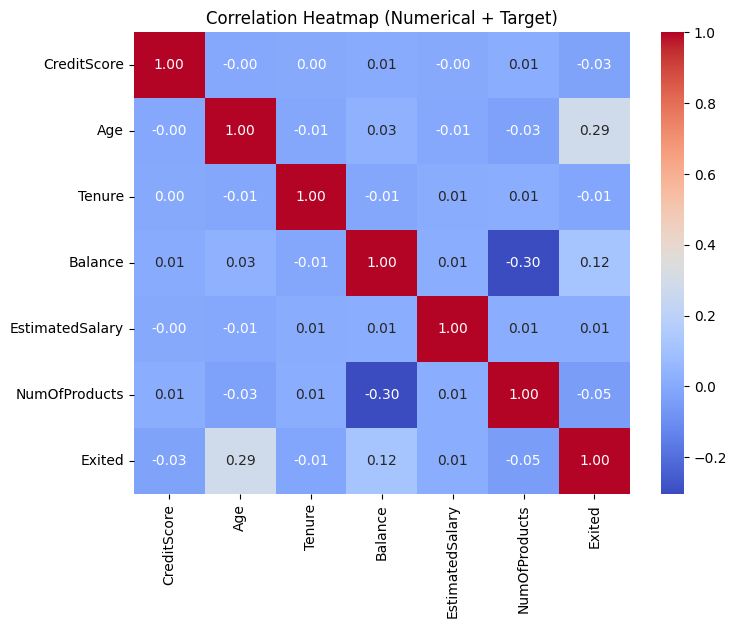

In [9]:
corr = df[num_cols + [target]].corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numerical + Target)')
plt.show()

In [10]:
def iqr_outlier_summary(data, cols):
    summary = {}
    for c in cols:
        q1, q3 = data[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        mask = (data[c] < lower) | (data[c] > upper)
        summary[c] = int(mask.sum())
    return pd.Series(summary)

iqr_summary = iqr_outlier_summary(df, num_cols)
iqr_summary.to_frame('outliers_count')

outliers_count
CreditScore                  15
Age                         359
Tenure                        0
Balance                       0
EstimatedSalary               0
NumOfProducts                60

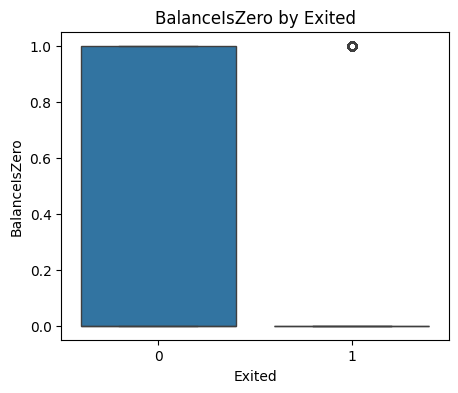

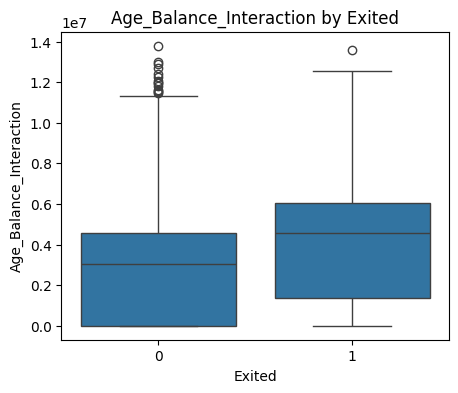


Churn Rate by AgeBin:
AgeBin
46–60    51.12%
60+      24.78%
36–45    19.62%
26–35      8.5%
18–25     7.53%
Name: Exited, dtype: object


In [11]:
# Ex1: Is the balance zero?
df['BalanceIsZero'] = (df['Balance'] == 0).astype(int)

# Ex2: Interaction term between age and balance
df['Age_Balance_Interaction'] = df['Age'] * df['Balance']

# Ex3: Arbitrary partitioning
df['AgeBin'] = pd.cut(df['Age'], bins=[18,25,35,45,60,100],
                      labels=['18–25','26–35','36–45','46–60','60+'], include_lowest=True)

# Examining the Relationship Between New Features and Customer Churn
for col in ['BalanceIsZero','Age_Balance_Interaction','AgeBin']:
    if col in df.select_dtypes(include='number').columns:
        plt.figure(figsize=(5,4))
        sns.boxplot(x=target, y=col, data=df)
        plt.title(f'{col} by {target}')
        plt.show()
    else:
        rate = df.groupby(col)[target].mean().sort_values(ascending=False)
        print(f"\nChurn Rate by {col}:\n{(rate*100).round(2).astype(str) + '%'}")

In [12]:
print("=== Key EDA Insights (Draft) ===")
print(f"- Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns; no critical missing values found.")
print("- Numerical distributions show skewness in Balance and EstimatedSalary; consider log/robust scaling in modelling.")
print("- Churn rate by Geography (top to bottom):")
print((df.groupby('Geography')['Exited'].mean().sort_values(ascending=False)*100).round(2).astype(str)+'%')
print("- Churn rate by Gender:")
print((df.groupby('Gender')['Exited'].mean()*100).round(2).astype(str)+'%')
print("- Active members churn less on average; examine IsActiveMember as a strong predictor.")
print("- Correlation heatmap suggests which numerical features align with churn; pair with domain logic for feature selection.")

=== Key EDA Insights (Draft) ===
- Dataset shape: 10000 rows × 14 columns; no critical missing values found.
- Numerical distributions show skewness in Balance and EstimatedSalary; consider log/robust scaling in modelling.
- Churn rate by Geography (top to bottom):
Geography
Germany    32.44%
Spain      16.67%
France     16.15%
Name: Exited, dtype: object
- Churn rate by Gender:
Gender
Female    25.07%
Male      16.46%
Name: Exited, dtype: object
- Active members churn less on average; examine IsActiveMember as a strong predictor.
- Correlation heatmap suggests which numerical features align with churn; pair with domain logic for feature selection.


In [13]:
# Export data
df.to_csv('Churn_Cleaned_For_Model.csv', index=False)

# from google.colab import files
# files.download('Churn_Cleaned_For_Model.csv')

In [14]:
# Importing Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [15]:
# %matplotlib inline

In [16]:
# Load the dataset
Churn_Cleaned_For_Model = pd.read_csv('Churn_Cleaned_For_Model.csv')
# Display the first few rows of the dataset
print(Churn_Cleaned_For_Model.head())
# Display summary statistics of the dataset
print(Churn_Cleaned_For_Model.describe())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  BalanceIsZero  \
0          1               1        101348.88       1              1   
1          0               1        112542.58       0              0   
2          1               0        113931.57       1              0   
3          0               0         93826.63       0              1   
4          1               1         79084.10       0              0   

   Age_Balance_Interaction AgeBin  
0                     0.00  36–45  
1               3436122.26  36–45  
2       

In [17]:
# Convert categorical variables to dummy variables
Churn_Cleaned_For_Model = pd.get_dummies(Churn_Cleaned_For_Model)

In [18]:
# Split the data into features and target variable
x = Churn_Cleaned_For_Model.drop('Exited', axis=1)
y = Churn_Cleaned_For_Model['Exited']

In [19]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

In [20]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8000, 20), (2000, 20), (8000,), (2000,))

In [21]:
# Create baseline model that always predicts the majority class
baseline_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED)
baseline_model.fit(x_train, y_train)
baseline_pred = baseline_model.predict(x_test)

baseline_accuracy = accuracy_score(y_test, baseline_pred)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

Baseline Accuracy: 0.7965


In [22]:
# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_SEED),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Store results
cv_results = {}
trained_models = {}

# Performing 5-Fold Cross-Validation

for name, model in models.items():
    print(f"Training {name}...")

    # Cross-validation scores
    cv_scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy')
    cv_results[name] = cv_scores

    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"  Individual fold scores: {[f'{s:.4f}' for s in cv_scores]}")

    # Train on full training set
    model.fit(x_train, y_train)
    trained_models[name] = model

Training Decision Tree...
  CV Accuracy: 0.8476 (+/- 0.0228)
  Individual fold scores: ['0.8512', '0.8562', '0.8588', '0.8269', '0.8450']
Training Random Forest...
  CV Accuracy: 0.8474 (+/- 0.0137)
  Individual fold scores: ['0.8413', '0.8575', '0.8538', '0.8425', '0.8419']
Training Logistic Regression...
  CV Accuracy: 0.8235 (+/- 0.0151)
  Individual fold scores: ['0.8225', '0.8250', '0.8350', '0.8113', '0.8237']


In [23]:
# Store all metrics
results_summary = []

for name, model in trained_models.items():
    print(f"\n{'='*80}")
    print(f"{name.upper()}")
    print(f"{'='*80}")

    # Predictions
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results_summary.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })

    # Print metrics
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC AUC:   {roc_auc:.4f}")

    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Exited', 'Exited']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"                No    Yes")
    print(f"Actual  No    {cm[0,0]:5d} {cm[0,1]:5d}")
    print(f"        Yes   {cm[1,0]:5d} {cm[1,1]:5d}")

# Create results dataframe
results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('ROC AUC', ascending=False)
print(results_df.to_string(index=False))


DECISION TREE

Performance Metrics:
  Accuracy:  0.8560
  Precision: 0.8051
  Recall:    0.3857
  F1-Score:  0.5216
  ROC AUC:   0.8307

Detailed Classification Report:
              precision    recall  f1-score   support

  Not Exited       0.86      0.98      0.92      1593
      Exited       0.81      0.39      0.52       407

    accuracy                           0.86      2000
   macro avg       0.83      0.68      0.72      2000
weighted avg       0.85      0.86      0.84      2000


Confusion Matrix:
                Predicted
                No    Yes
Actual  No     1555    38
        Yes     250   157

RANDOM FOREST

Performance Metrics:
  Accuracy:  0.8545
  Precision: 0.8295
  Recall:    0.3587
  F1-Score:  0.5009
  ROC AUC:   0.8446

Detailed Classification Report:
              precision    recall  f1-score   support

  Not Exited       0.86      0.98      0.91      1593
      Exited       0.83      0.36      0.50       407

    accuracy                           0.85   

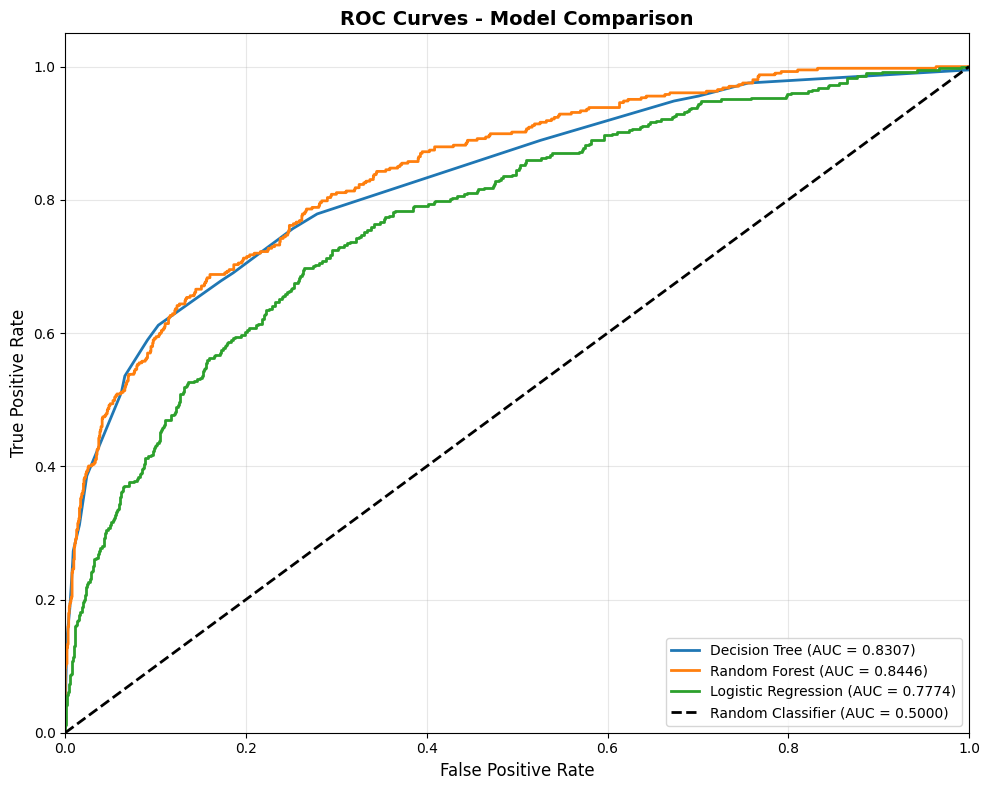

In [24]:
# ROC CURVES
plt.figure(figsize=(10, 8))

for name, model in trained_models.items():
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

1. NumOfProducts: 0.2240
2. Age: 0.2217
3. AgeBin_46–60: 0.1668
4. Age_Balance_Interaction: 0.0815
5. IsActiveMember: 0.0745
6. Geography_Germany: 0.0569
7. AgeBin_26–35: 0.0489
8. Balance: 0.0321
9. CreditScore: 0.0161
10. AgeBin_36–45: 0.0147


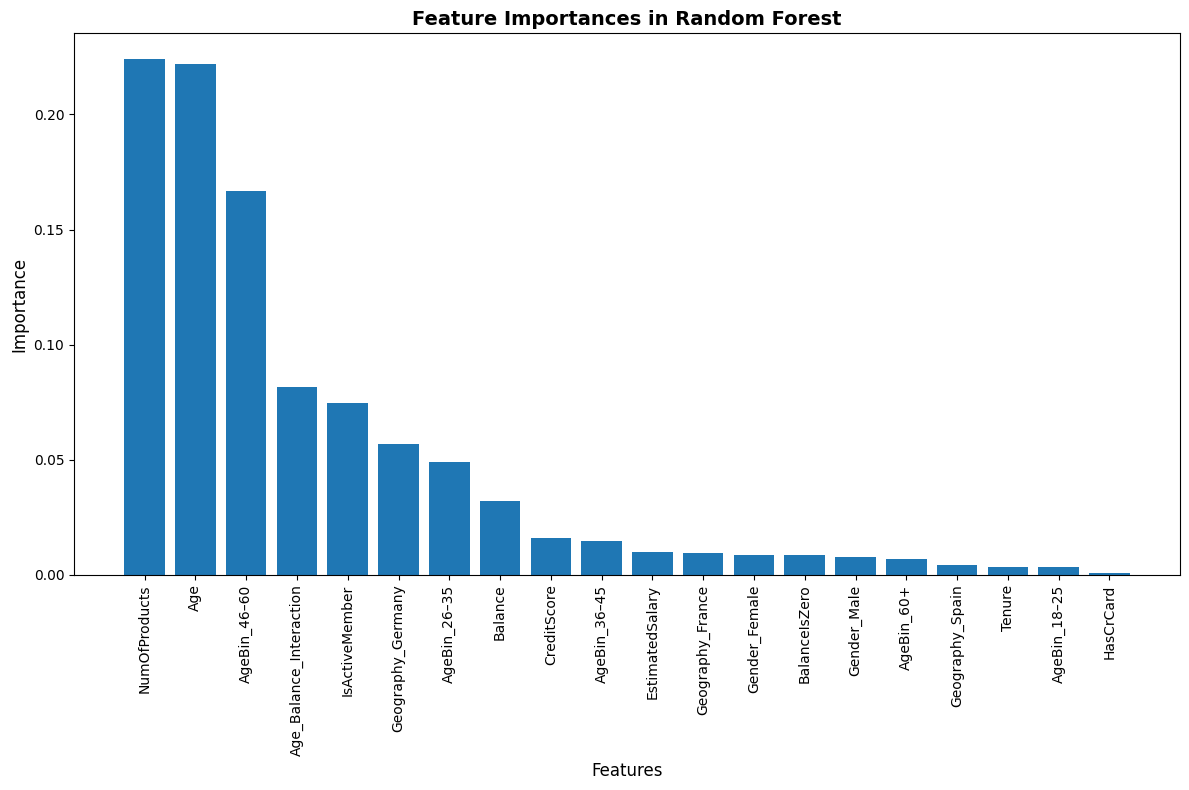

In [25]:
# FEATURE IMPORTANCE (RANDOM FOREST)
best_model = trained_models['Random Forest']
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print top 10 features
for i in range(min(10, len(indices))):
    print(f"{i+1}. {x.columns[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances in Random Forest', fontsize=14, fontweight='bold')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), x.columns[indices], rotation=90)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

In [26]:
# FAIRNESS ANALYSIS

# We need to analyze fairness on the original test set with demographic info
# Reconstruct test set with original features
test_indices = x_test.index
df_test = df.loc[test_indices].copy()
df_test['Predicted'] = best_model.predict(x_test)
df_test['Predicted_Proba'] = best_model.predict_proba(x_test)[:, 1]
df_test['Actual'] = y_test.values

# Function to calculate fairness metrics
def calculate_fairness_metrics(df, group_col, group_values):
    fairness_results = []

    for group in group_values:
        group_data = df[df[group_col] == group]

        if len(group_data) == 0:
            continue

        accuracy = accuracy_score(group_data['Actual'], group_data['Predicted'])
        precision = precision_score(group_data['Actual'], group_data['Predicted'], zero_division=0)
        recall = recall_score(group_data['Actual'], group_data['Predicted'], zero_division=0)
        f1 = f1_score(group_data['Actual'], group_data['Predicted'], zero_division=0)

        # False Negative Rate
        cm = confusion_matrix(group_data['Actual'], group_data['Predicted'])
        if cm.shape == (2, 2):
            fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
        else:
            fnr = 0

        fairness_results.append({
            'Group': f"{group_col}_{group}",
            'Sample_Size': len(group_data),
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'FNR': fnr
        })

    return pd.DataFrame(fairness_results)

# Analyze by Gender
print("Fairness Analysis by Gender:")
gender_fairness = calculate_fairness_metrics(df_test, 'Gender', ['Male', 'Female'])
print(gender_fairness.to_string(index=False))

# Analyze by Geography
print("Fairness Analysis by Geography:")
geo_fairness = calculate_fairness_metrics(df_test, 'Geography', ['France', 'Germany', 'Spain'])
print(geo_fairness.to_string(index=False))

# Combined fairness table
fairness_combined = pd.concat([gender_fairness, geo_fairness], ignore_index=True)
print("Combined Fairness Analysis:")
print(fairness_combined.to_string(index=False))

# Check for disparities
# Gender disparity
gender_acc_diff = abs(gender_fairness.iloc[0]['Accuracy'] - gender_fairness.iloc[1]['Accuracy'])
print(f"Gender Accuracy Difference: {gender_acc_diff:.4f} ({gender_acc_diff*100:.2f}%)")

# Geography disparity
geo_acc_max = geo_fairness['Accuracy'].max()
geo_acc_min = geo_fairness['Accuracy'].min()
geo_acc_diff = geo_acc_max - geo_acc_min
print(f"Geography Accuracy Difference: {geo_acc_diff:.4f} ({geo_acc_diff*100:.2f}%)")


Fairness Analysis by Gender:
        Group  Sample_Size  Accuracy  Precision   Recall       F1      FNR
  Gender_Male         1070  0.880374   0.819444 0.339080 0.479675 0.660920
Gender_Female          930  0.824731   0.836538 0.373391 0.516320 0.626609
Fairness Analysis by Geography:
            Group  Sample_Size  Accuracy  Precision   Recall       F1      FNR
 Geography_France         1021  0.869736   0.888889 0.274286 0.419214 0.725714
Geography_Germany          504  0.809524   0.783505 0.503311 0.612903 0.496689
  Geography_Spain          475  0.869474   0.880000 0.271605 0.415094 0.728395
Combined Fairness Analysis:
            Group  Sample_Size  Accuracy  Precision   Recall       F1      FNR
      Gender_Male         1070  0.880374   0.819444 0.339080 0.479675 0.660920
    Gender_Female          930  0.824731   0.836538 0.373391 0.516320 0.626609
 Geography_France         1021  0.869736   0.888889 0.274286 0.419214 0.725714
Geography_Germany          504  0.809524   0.783505 0.

In [27]:
# BUSINESS VALUE CALCULATION
# Business assumptions
avg_customer_value = 5000  # £5,000 per customer
intervention_cost = 150    # £150 per intervention
current_churn_rate = df[target].mean()
total_customers = len(df)

print("Business Assumptions:")
print(f"  Average Customer Lifetime Value: £{avg_customer_value:,}")
print(f"  Intervention Cost per Customer: £{intervention_cost:,}")
print(f"  Current Churn Rate: {current_churn_rate*100:.2f}%")
print(f"  Total Customers: {total_customers:,}")

# Strategy: Target top 20% highest risk customers
df_test_sorted = df_test.sort_values('Predicted_Proba', ascending=False)
top_20_pct = int(len(df_test_sorted) * 0.2)
top_20_customers = df_test_sorted.head(top_20_pct)

# Calculate metrics for top 20%
churners_in_top_20 = top_20_customers['Actual'].sum()
total_churners = df_test['Actual'].sum()
capture_rate = churners_in_top_20 / total_churners if total_churners > 0 else 0

# Lift calculation
baseline_churn_in_top_20 = top_20_pct * current_churn_rate
lift = churners_in_top_20 / baseline_churn_in_top_20 if baseline_churn_in_top_20 > 0 else 0

print(f"Targeting Strategy: Top 20% Highest Risk")
print(f"  Customers Targeted: {top_20_pct}")
print(f"  Actual Churners Captured: {churners_in_top_20}")
print(f"  Capture Rate: {capture_rate*100:.2f}%")
print(f"  Lift over Random: {lift:.2f}x")

# Assume 60% intervention success rate
intervention_success_rate = 0.6
prevented_churns = int(churners_in_top_20 * intervention_success_rate)

# Calculate financial impact
revenue_saved = prevented_churns * avg_customer_value
intervention_costs = top_20_pct * intervention_cost
net_benefit = revenue_saved - intervention_costs
roi = net_benefit / intervention_costs if intervention_costs > 0 else 0

print(f"Financial Impact (Test Set):")
print(f"  Prevented Churns: {prevented_churns}")
print(f"  Revenue Saved: £{revenue_saved:,}")
print(f"  Intervention Costs: £{intervention_costs:,}")
print(f"  Net Benefit: £{net_benefit:,}")
print(f"  ROI: {roi:.2f}:1")

# Project to full dataset
scale_factor = total_customers / len(df_test)
annual_prevented_churns = int(prevented_churns * scale_factor)
annual_revenue_saved = int(revenue_saved * scale_factor)
annual_intervention_costs = int(intervention_costs * scale_factor)
annual_net_benefit = annual_revenue_saved - annual_intervention_costs
annual_roi = annual_net_benefit / annual_intervention_costs if annual_intervention_costs > 0 else 0

print(f"Projected Annual Impact:")
print(f"  Prevented Churns: {annual_prevented_churns:,}")
print(f"  Revenue Saved: £{annual_revenue_saved:,}")
print(f"  Intervention Costs: £{annual_intervention_costs:,}")
print(f"  Net Benefit: £{annual_net_benefit:,}")
print(f"  ROI: {annual_roi:.2f}:1")

# Churn rate reduction
new_churn_rate = (total_customers * current_churn_rate - annual_prevented_churns) / total_customers
churn_reduction = current_churn_rate - new_churn_rate

print(f"\nChurn Rate Impact:")
print(f"  Current Churn Rate: {current_churn_rate*100:.2f}%")
print(f"  Projected New Churn Rate: {new_churn_rate*100:.2f}%")
print(f"  Reduction: {churn_reduction*100:.2f} percentage points")

business_metrics = {
    'Metric': [
        'Total Customers',
        'Current Churn Rate (%)',
        'Customers Targeted (20%)',
        'Churners Captured',
        'Capture Rate (%)',
        'Lift over Random',
        'Intervention Success Rate (%)',
        'Annual Prevented Churns',
        'Annual Revenue Saved (£)',
        'Annual Intervention Costs (£)',
        'Annual Net Benefit (£)',
        'ROI',
        'New Churn Rate (%)',
        'Churn Reduction (pp)'
    ],
    'Value': [
        f"{total_customers:,}",
        f"{current_churn_rate*100:.2f}",
        f"{int(total_customers*0.2):,}",
        f"{int(churners_in_top_20 * scale_factor):,}",
        f"{capture_rate*100:.2f}",
        f"{lift:.2f}x",
        f"{intervention_success_rate*100:.0f}",
        f"{annual_prevented_churns:,}",
        f"{annual_revenue_saved:,}",
        f"{annual_intervention_costs:,}",
        f"{annual_net_benefit:,}",
        f"{annual_roi:.2f}:1",
        f"{new_churn_rate*100:.2f}",
        f"{churn_reduction*100:.2f}"
    ]
}
business_df = pd.DataFrame(business_metrics)
print(business_df)

Business Assumptions:
  Average Customer Lifetime Value: £5,000
  Intervention Cost per Customer: £150
  Current Churn Rate: 20.37%
  Total Customers: 10,000
Targeting Strategy: Top 20% Highest Risk
  Customers Targeted: 400
  Actual Churners Captured: 241
  Capture Rate: 59.21%
  Lift over Random: 2.96x
Financial Impact (Test Set):
  Prevented Churns: 144
  Revenue Saved: £720,000
  Intervention Costs: £60,000
  Net Benefit: £660,000
  ROI: 11.00:1
Projected Annual Impact:
  Prevented Churns: 720
  Revenue Saved: £3,600,000
  Intervention Costs: £300,000
  Net Benefit: £3,300,000
  ROI: 11.00:1

Churn Rate Impact:
  Current Churn Rate: 20.37%
  Projected New Churn Rate: 13.17%
  Reduction: 7.20 percentage points
                           Metric      Value
0                 Total Customers     10,000
1          Current Churn Rate (%)      20.37
2        Customers Targeted (20%)      2,000
3               Churners Captured      1,205
4                Capture Rate (%)      59.21
5      

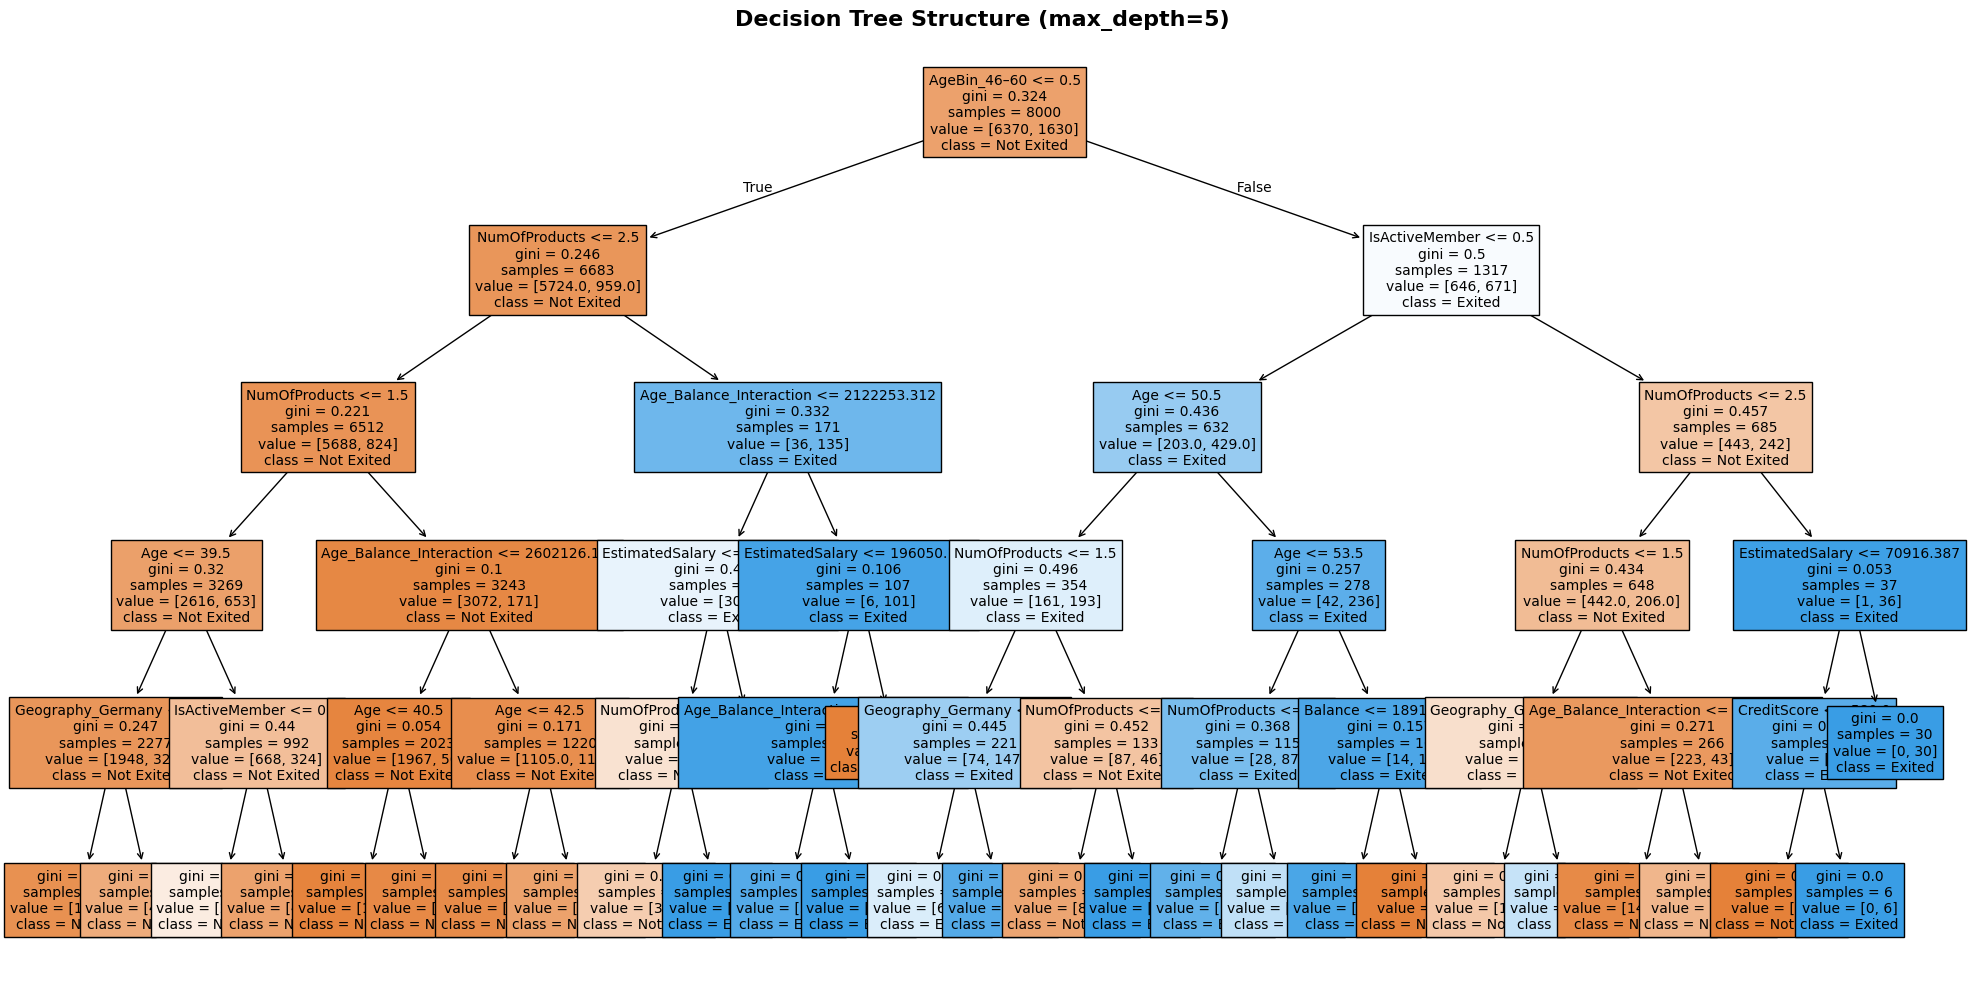

In [28]:
# DECISION TREE VISUALIZATION

plt.figure(figsize=(20,10))
plot_tree(trained_models['Decision Tree'], filled=True,
          feature_names=x.columns,
          class_names=['Not Exited', 'Exited'],
          fontsize=10)
plt.title('Decision Tree Structure (max_depth=5)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

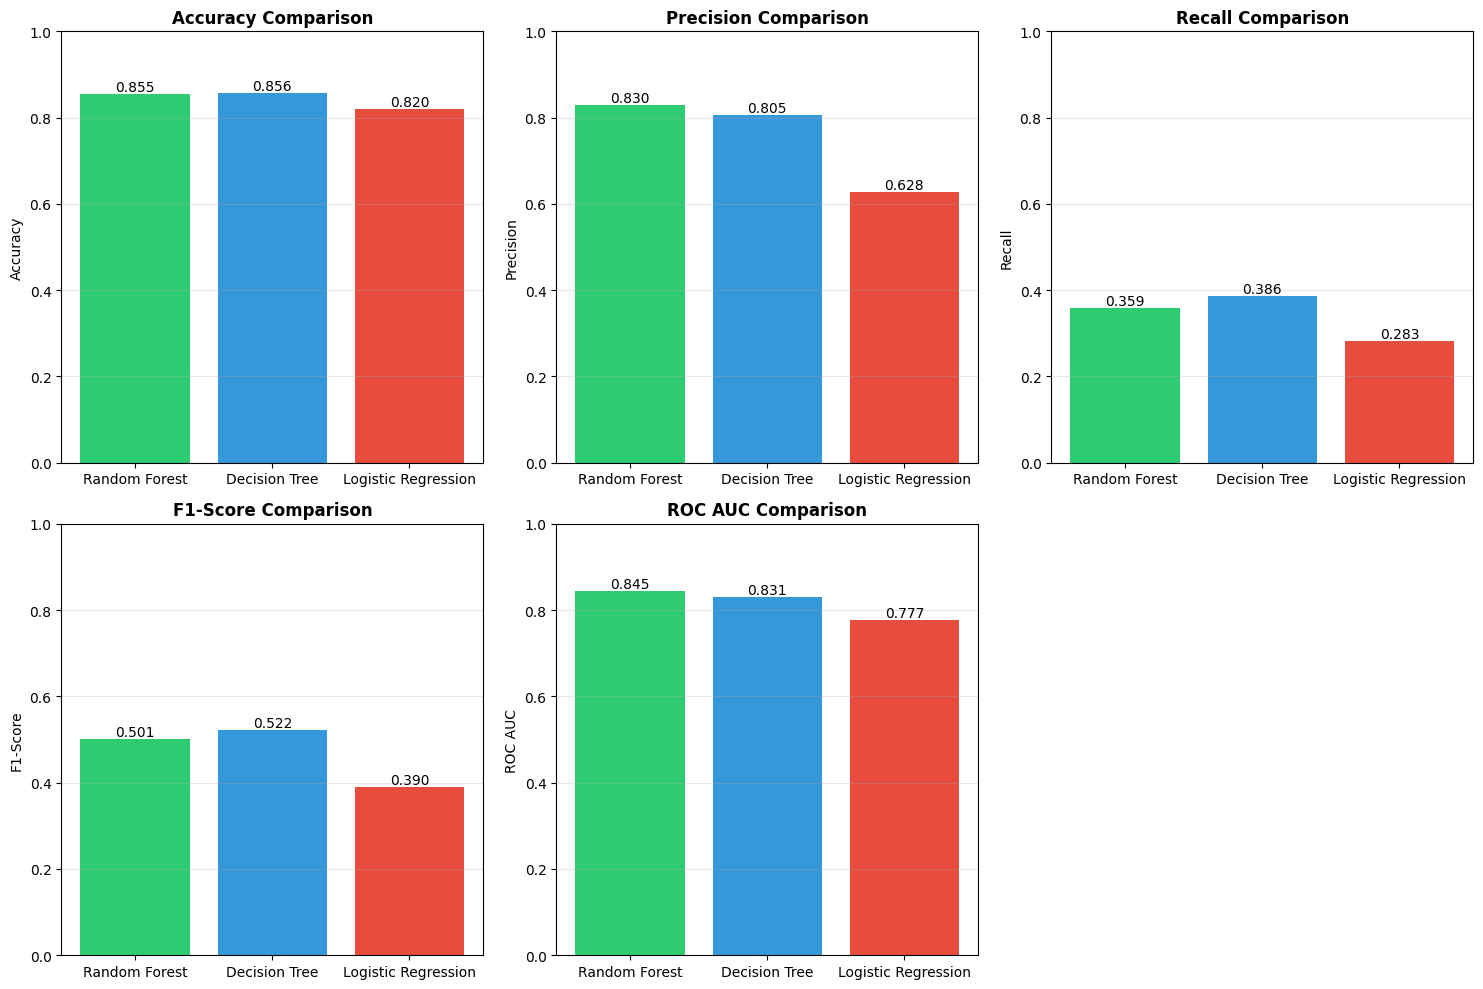

In [32]:
# 1. Model Comparison Bar Chart
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
models = list(results_df['Model'])

for idx, metric in enumerate(metrics):
    ax = axes[idx//3, idx%3]
    values = results_df[metric].values
    bars = ax.bar(models, values, color=['#2ecc71', '#3498db', '#e74c3c'])
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.set_ylabel(metric)
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')
    ax.grid(axis='y', alpha=0.3)

# Remove empty subplot
axes[1, 2].axis('off')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

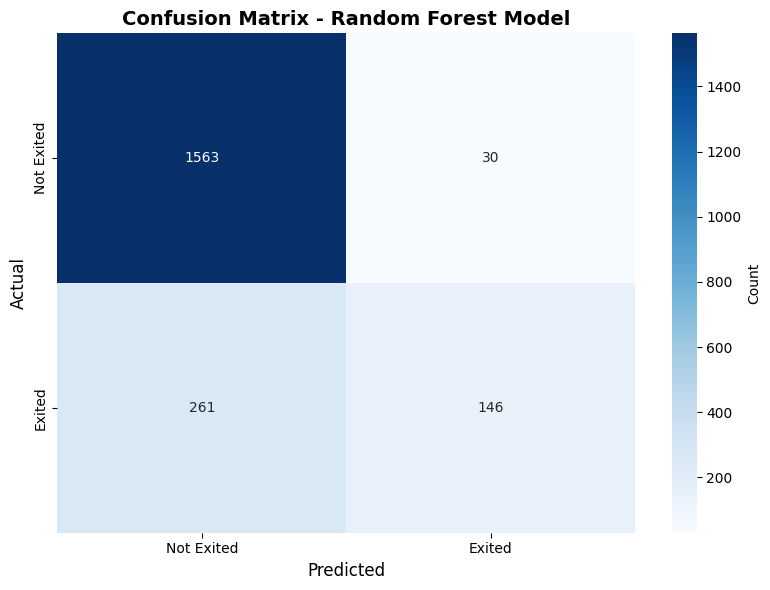

In [33]:
# 2. Confusion Matrix Heatmap for Random Forest
from sklearn.metrics import confusion_matrix

y_pred_rf = trained_models['Random Forest'].predict(x_test)
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Exited', 'Exited'],
            yticklabels=['Not Exited', 'Exited'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest Model', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

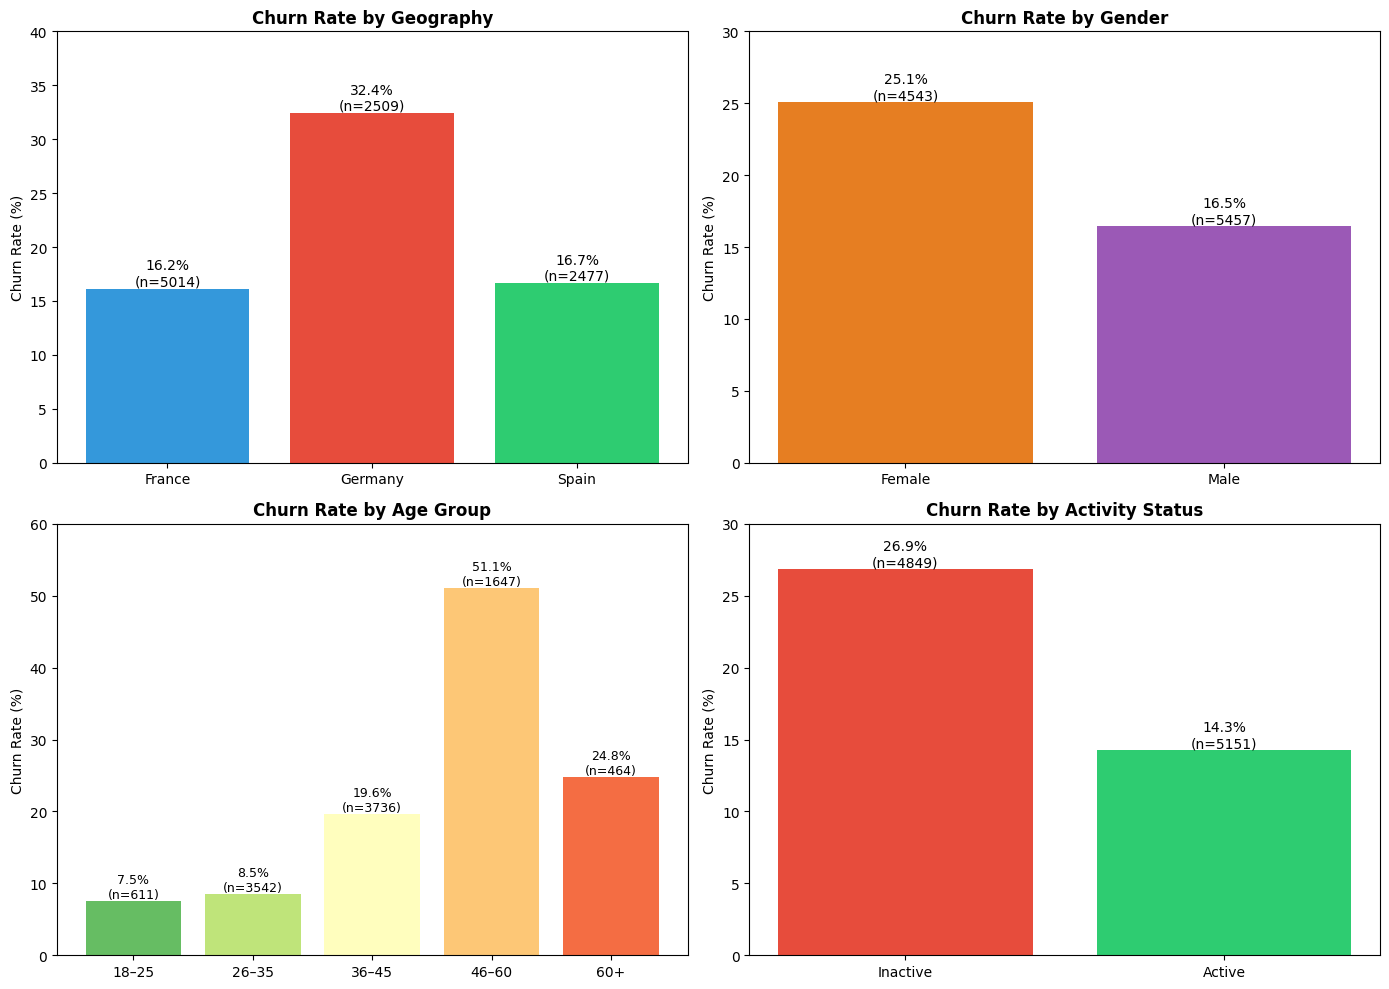

In [34]:
# 3. Churn Rate by Key Segments
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Geography
geo_churn = df.groupby('Geography')['Exited'].agg(['mean', 'count'])
ax1 = axes[0, 0]
bars = ax1.bar(geo_churn.index, geo_churn['mean']*100,
               color=['#3498db', '#e74c3c', '#2ecc71'])
ax1.set_title('Churn Rate by Geography', fontsize=12, fontweight='bold')
ax1.set_ylabel('Churn Rate (%)')
ax1.set_ylim([0, 40])
for i, (bar, count) in enumerate(zip(bars, geo_churn['count'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n(n={count})', ha='center', va='bottom')

# Gender
gender_churn = df.groupby('Gender')['Exited'].agg(['mean', 'count'])
ax2 = axes[0, 1]
bars = ax2.bar(gender_churn.index, gender_churn['mean']*100,
               color=['#e67e22', '#9b59b6'])
ax2.set_title('Churn Rate by Gender', fontsize=12, fontweight='bold')
ax2.set_ylabel('Churn Rate (%)')
ax2.set_ylim([0, 30])
for i, (bar, count) in enumerate(zip(bars, gender_churn['count'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n(n={count})', ha='center', va='bottom')

# Age Bins
agebin_churn = df.groupby('AgeBin')['Exited'].agg(['mean', 'count'])
ax3 = axes[1, 0]
bars = ax3.bar(range(len(agebin_churn)), agebin_churn['mean']*100,
               color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(agebin_churn))))
ax3.set_title('Churn Rate by Age Group', fontsize=12, fontweight='bold')
ax3.set_ylabel('Churn Rate (%)')
ax3.set_xticks(range(len(agebin_churn)))
ax3.set_xticklabels(agebin_churn.index, rotation=0)
ax3.set_ylim([0, 60])
for i, (bar, count) in enumerate(zip(bars, agebin_churn['count'])):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=9)

# Active Member
active_churn = df.groupby('IsActiveMember')['Exited'].agg(['mean', 'count'])
ax4 = axes[1, 1]
bars = ax4.bar(['Inactive', 'Active'], active_churn['mean']*100,
               color=['#e74c3c', '#2ecc71'])
ax4.set_title('Churn Rate by Activity Status', fontsize=12, fontweight='bold')
ax4.set_ylabel('Churn Rate (%)')
ax4.set_ylim([0, 30])
for i, (bar, count) in enumerate(zip(bars, active_churn['count'])):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%\n(n={count})', ha='center', va='bottom')

plt.tight_layout()
plt.show()

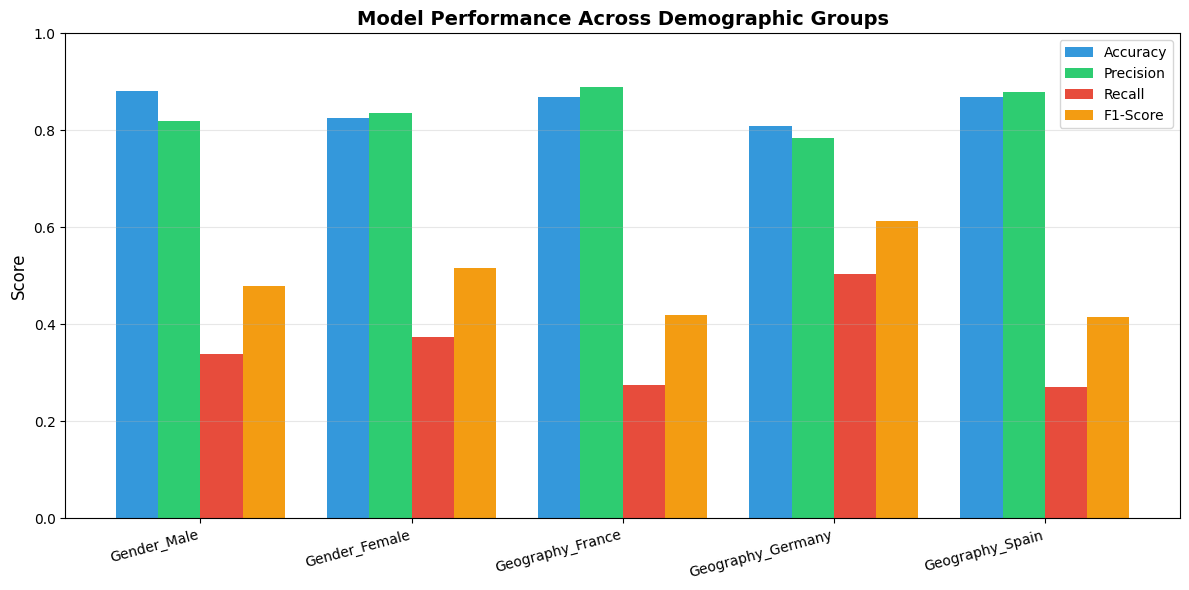

In [35]:
# 4. Fairness Comparison Chart
fairness_metrics = fairness_combined[['Group', 'Accuracy', 'Precision', 'Recall', 'F1']]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(fairness_metrics))
width = 0.2

ax.bar(x - 1.5*width, fairness_metrics['Accuracy'], width, label='Accuracy', color='#3498db')
ax.bar(x - 0.5*width, fairness_metrics['Precision'], width, label='Precision', color='#2ecc71')
ax.bar(x + 0.5*width, fairness_metrics['Recall'], width, label='Recall', color='#e74c3c')
ax.bar(x + 1.5*width, fairness_metrics['F1'], width, label='F1-Score', color='#f39c12')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Across Demographic Groups', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(fairness_metrics['Group'], rotation=15, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

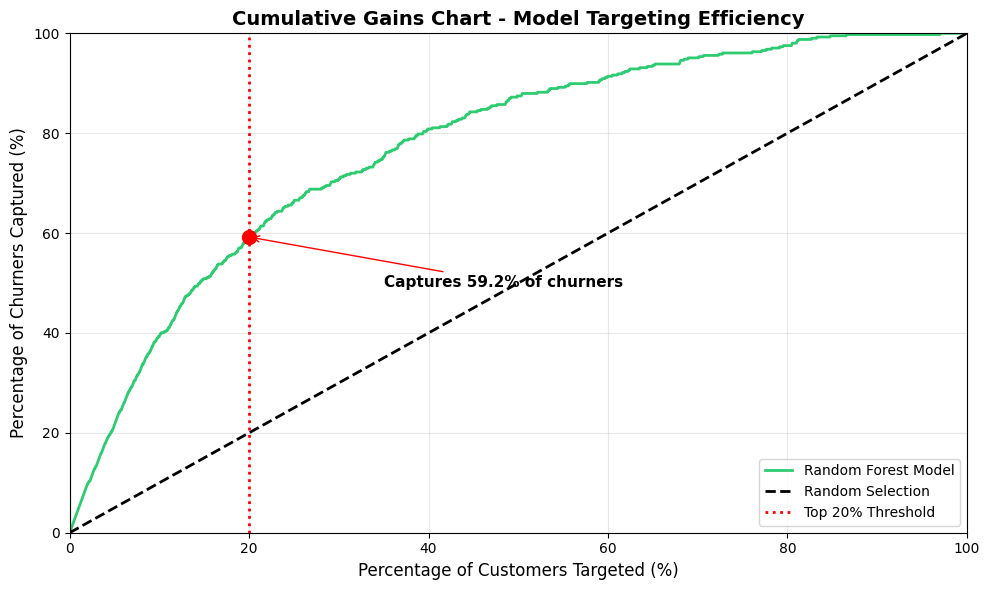

In [36]:
# 5. Cumulative Gains Chart
from sklearn.metrics import auc

df_test_sorted_copy = df_test.sort_values('Predicted_Proba', ascending=False).copy()
df_test_sorted_copy['cumulative_actual'] = df_test_sorted_copy['Actual'].cumsum()
df_test_sorted_copy['cumulative_pct'] = np.arange(1, len(df_test_sorted_copy)+1) / len(df_test_sorted_copy)
df_test_sorted_copy['gains'] = df_test_sorted_copy['cumulative_actual'] / df_test_sorted_copy['Actual'].sum()

plt.figure(figsize=(10, 6))
plt.plot(df_test_sorted_copy['cumulative_pct']*100,
         df_test_sorted_copy['gains']*100,
         label='Random Forest Model', linewidth=2, color='#2ecc71')
plt.plot([0, 100], [0, 100], 'k--', label='Random Selection', linewidth=2)
plt.axvline(x=20, color='r', linestyle=':', linewidth=2, label='Top 20% Threshold')

# Mark the point at 20%
idx_20 = int(len(df_test_sorted_copy) * 0.2)
gains_at_20 = df_test_sorted_copy.iloc[idx_20]['gains'] * 100
plt.plot(20, gains_at_20, 'ro', markersize=10)
plt.annotate(f'Captures {gains_at_20:.1f}% of churners',
             xy=(20, gains_at_20), xytext=(35, gains_at_20-10),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=11, fontweight='bold')

plt.xlabel('Percentage of Customers Targeted (%)', fontsize=12)
plt.ylabel('Percentage of Churners Captured (%)', fontsize=12)
plt.title('Cumulative Gains Chart - Model Targeting Efficiency', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.tight_layout()
plt.show()

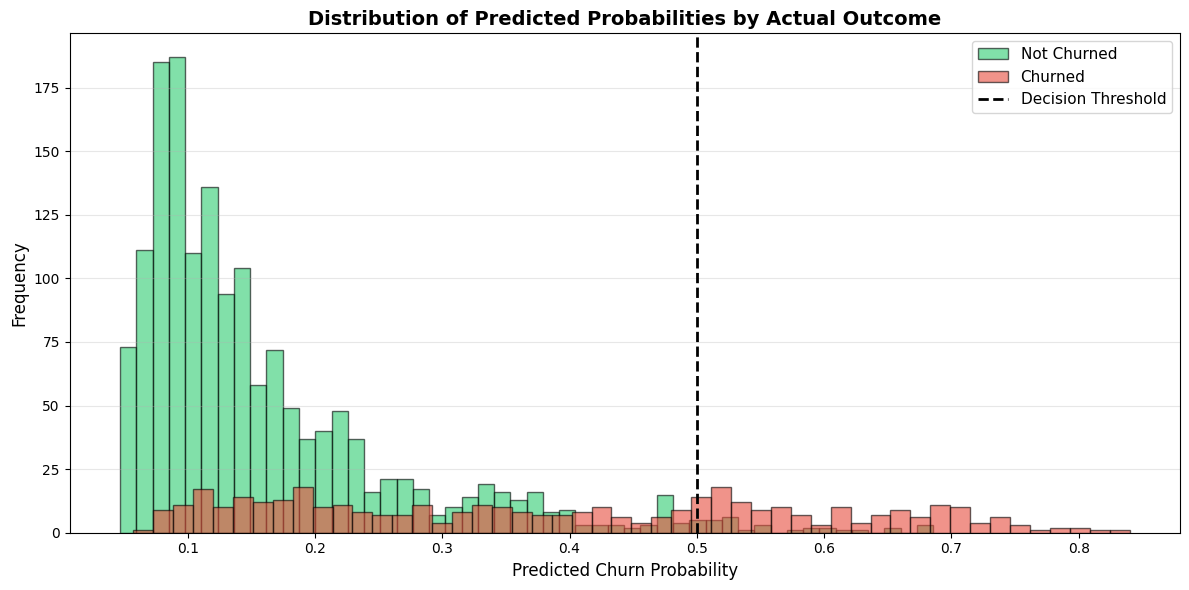

In [37]:
# 6. Predicted Probability Distribution
plt.figure(figsize=(12, 6))
plt.hist(df_test[df_test['Actual']==0]['Predicted_Proba'], bins=50,
         alpha=0.6, label='Not Churned', color='#2ecc71', edgecolor='black')
plt.hist(df_test[df_test['Actual']==1]['Predicted_Proba'], bins=50,
         alpha=0.6, label='Churned', color='#e74c3c', edgecolor='black')
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
plt.xlabel('Predicted Churn Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Predicted Probabilities by Actual Outcome', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

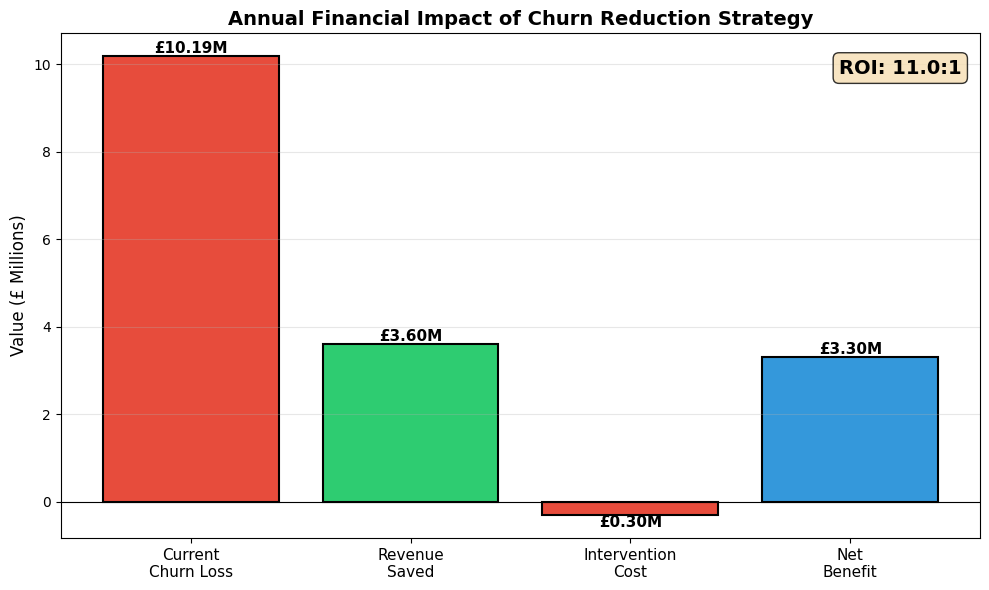

In [38]:
# 7. Business Value Waterfall Chart
import matplotlib.patches as mpatches

categories = ['Current\nChurn Loss', 'Revenue\nSaved', 'Intervention\nCost', 'Net\nBenefit']
values = [total_customers * current_churn_rate * avg_customer_value / 1000000,  # Convert to millions
          annual_revenue_saved / 1000000,
          -annual_intervention_costs / 1000000,
          annual_net_benefit / 1000000]

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c', '#2ecc71', '#e74c3c', '#3498db']

# Create waterfall
x_pos = np.arange(len(categories))
bars = ax.bar(x_pos, values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, values)):
    height = bar.get_height()
    label = f'£{abs(val):.2f}M'
    if val >= 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontweight='bold', fontsize=11)
    else:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='top', fontweight='bold', fontsize=11)

ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylabel('Value (£ Millions)', fontsize=12)
ax.set_title('Annual Financial Impact of Churn Reduction Strategy', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='y', alpha=0.3)

# Add ROI annotation
ax.text(0.98, 0.95, f'ROI: {annual_roi:.1f}:1',
        transform=ax.transAxes, fontsize=14, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        ha='right', va='top')

plt.tight_layout()
plt.show()